In [1]:
import spacy
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd
import numpy as np
import nltk
import spacy
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk import pos_tag, ngrams, FreqDist, ConditionalFreqDist
from collections import defaultdict

# Load dataset
data = pd.read_csv("/kaggle/input/filtered-and-translated-nlp/filr.csv")
texts = data["Translated"].astype(str).tolist()
labels = data["Label"].tolist()
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

# POS Tagging
pos_tagged_texts = [pos_tag(tokens) for tokens in tokenized_texts]

### 1. Word2Vec + Classifiers (SVC & RF) ###
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

def get_w2v_features(tokens):
    return np.mean([word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv], axis=0)

X_w2v = np.array([get_w2v_features(tokens) if len(tokens) > 0 else np.zeros(100) for tokens in tokenized_texts])
X_train, X_test, y_train, y_test = train_test_split(X_w2v, labels, test_size=0.2, random_state=42)

svm_classifier = SVC(kernel='linear', probability=True)
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
svm_classifier.fit(X_train, y_train)
random_forest_classifier.fit(X_train, y_train)

y_pred_svm = svm_classifier.predict(X_test)
y_pred_rf = random_forest_classifier.predict(X_test)

### 2. GloVe + Classifiers (SVC & RF) ###
nlp = spacy.load("en_core_web_md")  # Pre-trained GloVe vectors

def get_glove_features(text):
    return nlp(text).vector

X_glove = np.array([get_glove_features(text) for text in texts])
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, labels, test_size=0.2, random_state=42)

svm_classifier_glove = SVC(kernel='linear', probability=True)
random_forest_classifier_glove = RandomForestClassifier(n_estimators=100, random_state=42)
svm_classifier_glove.fit(X_train_glove, y_train_glove)
random_forest_classifier_glove.fit(X_train_glove, y_train_glove)

y_pred_svm_glove = svm_classifier_glove.predict(X_test_glove)
y_pred_rf_glove = random_forest_classifier_glove.predict(X_test_glove)

predictions = {
    "SVM (Word2Vec)": (y_pred_svm, svm_classifier, X_w2v),
    "Random Forest (Word2Vec)": (y_pred_rf, random_forest_classifier, X_w2v),
    "SVM (GloVe)": (y_pred_svm_glove, svm_classifier_glove, X_glove),
    "Random Forest (GloVe)": (y_pred_rf_glove, random_forest_classifier_glove, X_glove),
}

correctly_classified_sentences = {}
misclassified_sentences = {}

for model, (preds, classifier, features) in predictions.items():
    correctly_classified_indices = np.where(preds == y_test)[0]
    misclassified_indices = np.where(preds != y_test)[0]
    correctly_classified_sentences[model] = [(texts[i], pos_tagged_texts[i], classifier.predict_proba([features[i]])[0]) for i in correctly_classified_indices]
    misclassified_sentences[model] = [(texts[i], pos_tagged_texts[i], classifier.predict_proba([features[i]])[0]) for i in misclassified_indices]

for model in correctly_classified_sentences:
    for text, correct_tags, correct_probs in correctly_classified_sentences[model]:
        for other_model in misclassified_sentences:
            misclassified_entries = [entry for entry in misclassified_sentences[other_model] if entry[0] == text]
            for misclassified_entry in misclassified_entries:
                _, misclassified_tags, misclassified_probs = misclassified_entry
                print(f"Sentence: {text}")
                print(f"Correctly classified by: {model}")
                print(f"Misclassified by: {other_model}")
                print(f"Correct POS Tags & Probabilities:")
                for (word, tag), prob in zip(correct_tags, correct_probs):
                    print(f"{word} ({tag}) → {prob:.2f}")
                print(f"Misclassified POS Tags & Probabilities:")
                for (word, tag), prob in zip(misclassified_tags, misclassified_probs):
                    print(f"{word} ({tag}) → {prob:.2f}")
                print("-")

Sentence: Who are the soldiers we see in the videos? Are they manipulated or real? Russians in Ukrainian uniforms or vice versa?

AI can shed light by identifying people in a necessary #debunking and fact checking.

In the infosphere, war is also informational. #fakenews
Correctly classified by: SVM (Word2Vec)
Misclassified by: SVM (GloVe)
Correct POS Tags & Probabilities:
who (WP) → 0.17
are (VBP) → 0.25
the (DT) → 0.42
soldiers (NNS) → 0.16
Misclassified POS Tags & Probabilities:
who (WP) → 0.21
are (VBP) → 0.22
the (DT) → 0.47
soldiers (NNS) → 0.10
-
Sentence: I didn't think #Salvini could make his position worse, his love for Putin, the subsequent silences, the bouquet of flowers at the embassy, the Pizza-maracaibo evening with the war in Kiev, but he managed.

"This yes," during the festive pizza party, "we talked about Ukraine."
Correctly classified by: SVM (Word2Vec)
Misclassified by: SVM (GloVe)
Correct POS Tags & Probabilities:
i (NN) → 0.14
did (VBD) → 0.27
n't (RB) → 0.41
th

SVM (Word2Vec) Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        20
           2       0.45      1.00      0.62        43
           3       0.00      0.00      0.00        17

    accuracy                           0.45        96
   macro avg       0.11      0.25      0.15        96
weighted avg       0.20      0.45      0.28        96



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


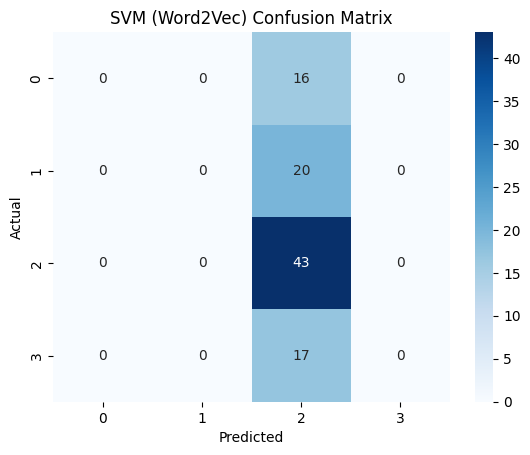

Random Forest (Word2Vec) Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.12      0.18        16
           1       0.12      0.10      0.11        20
           2       0.54      0.86      0.67        43
           3       0.40      0.12      0.18        17

    accuracy                           0.45        96
   macro avg       0.35      0.30      0.28        96
weighted avg       0.39      0.45      0.38        96



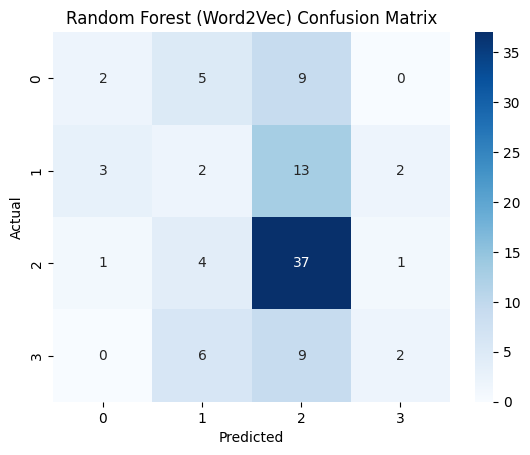

SVM (GloVe) Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.56      0.50        16
           1       0.32      0.45      0.38        20
           2       0.57      0.47      0.51        43
           3       0.46      0.35      0.40        17

    accuracy                           0.46        96
   macro avg       0.45      0.46      0.45        96
weighted avg       0.48      0.46      0.46        96



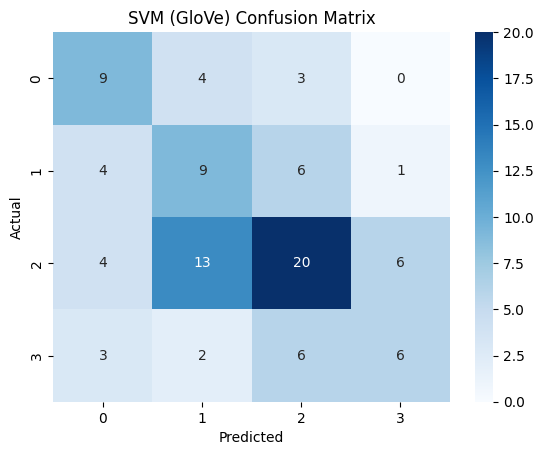

Random Forest (GloVe) Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.38      0.50        16
           1       0.44      0.35      0.39        20
           2       0.53      0.86      0.65        43
           3       1.00      0.12      0.21        17

    accuracy                           0.54        96
   macro avg       0.68      0.43      0.44        96
weighted avg       0.63      0.54      0.49        96



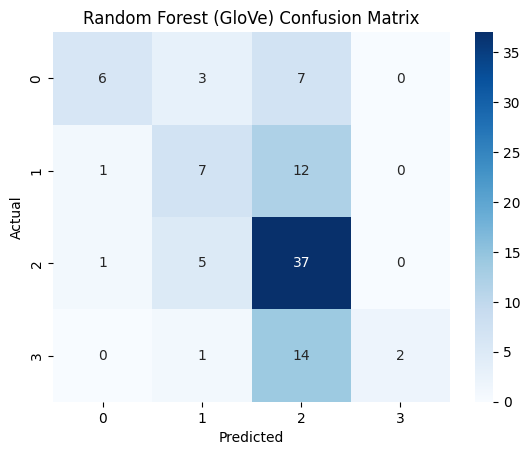

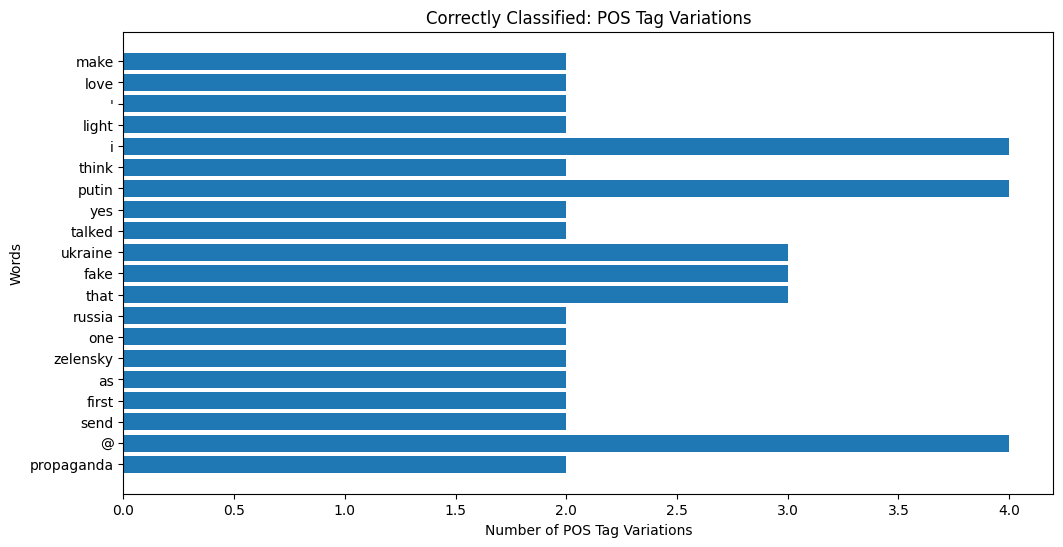

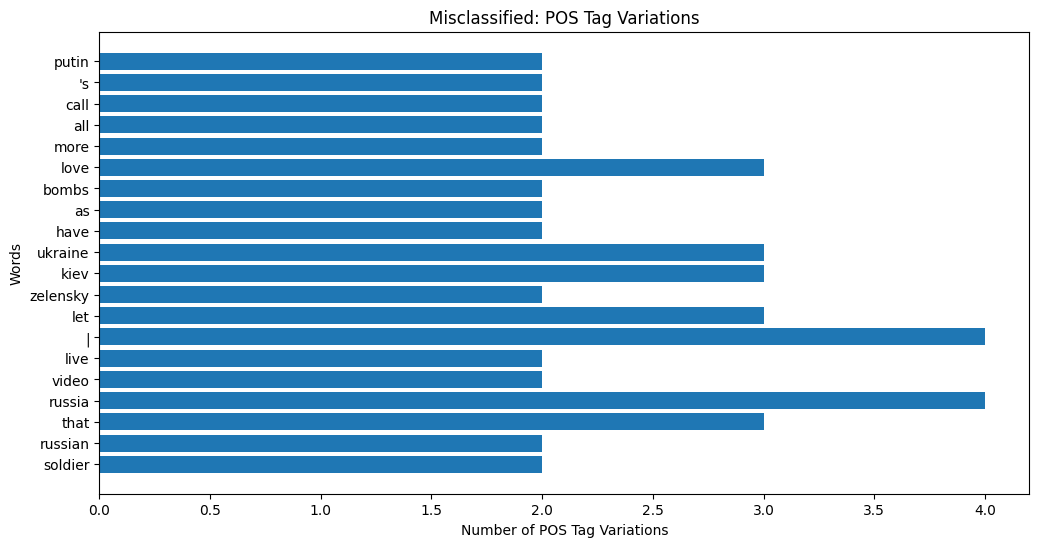

In [3]:
import pandas as pd
import numpy as np
import nltk
import spacy
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk import pos_tag, ngrams, FreqDist, ConditionalFreqDist
from collections import defaultdict

# Load dataset
data = pd.read_csv("/kaggle/input/filtered-and-translated-nlp/filr.csv")
texts = data["Translated"].astype(str).tolist()
labels = data["Label"].tolist()
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

# POS Tagging
pos_tagged_texts = [pos_tag(tokens) for tokens in tokenized_texts]

### 1. Word2Vec + Classifiers (SVC & RF) ###
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

def get_w2v_features(tokens):
    return np.mean([word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv], axis=0)

X_w2v = np.array([get_w2v_features(tokens) if len(tokens) > 0 else np.zeros(100) for tokens in tokenized_texts])
X_train, X_test, y_train, y_test = train_test_split(X_w2v, labels, test_size=0.2, random_state=42)

svm_classifier = SVC(kernel='linear', probability=True)
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
svm_classifier.fit(X_train, y_train)
random_forest_classifier.fit(X_train, y_train)

y_pred_svm = svm_classifier.predict(X_test)
y_pred_rf = random_forest_classifier.predict(X_test)

def evaluate_model(y_test, y_pred, model_name):
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

evaluate_model(y_test, y_pred_svm, "SVM (Word2Vec)")
evaluate_model(y_test, y_pred_rf, "Random Forest (Word2Vec)")

### 2. GloVe + Classifiers (SVC & RF) ###
nlp = spacy.load("en_core_web_md")  # Pre-trained GloVe vectors

def get_glove_features(text):
    return nlp(text).vector

X_glove = np.array([get_glove_features(text) for text in texts])
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, labels, test_size=0.2, random_state=42)

svm_classifier_glove = SVC(kernel='linear', probability=True)
random_forest_classifier_glove = RandomForestClassifier(n_estimators=100, random_state=42)
svm_classifier_glove.fit(X_train_glove, y_train_glove)
random_forest_classifier_glove.fit(X_train_glove, y_train_glove)

y_pred_svm_glove = svm_classifier_glove.predict(X_test_glove)
y_pred_rf_glove = random_forest_classifier_glove.predict(X_test_glove)

evaluate_model(y_test_glove, y_pred_svm_glove, "SVM (GloVe)")
evaluate_model(y_test_glove, y_pred_rf_glove, "Random Forest (GloVe)")

### 3. Extracting POS Tag Variations ###
def extract_possible_tags(pos_tagged_tokens):
    tag_variants = defaultdict(set)
    for word, tag in pos_tagged_tokens:
        tag_variants[word].add(tag)
    return tag_variants

correctly_classified_indices = np.where(y_pred_svm == y_test)[0]
misclassified_indices = np.where(y_pred_svm != y_test)[0]

correctly_classified_tags = [extract_possible_tags(pos_tagged_texts[i]) for i in correctly_classified_indices]
misclassified_tags = [extract_possible_tags(pos_tagged_texts[i]) for i in misclassified_indices]

word_tag_dist = ConditionalFreqDist()
for tag_set in correctly_classified_tags:
    for word, tags in tag_set.items():
        for tag in tags:
            word_tag_dist[word][tag] += 1

misclassified_word_tag_dist = ConditionalFreqDist()
for tag_set in misclassified_tags:
    for word, tags in tag_set.items():
        for tag in tags:
            misclassified_word_tag_dist[word][tag] += 1

### 4. Compare Probability Distributions of POS Tag Variations ###
def plot_tag_variation_distribution(word_tag_dist, title):
    plt.figure(figsize=(12,6))
    words, variations = zip(*[(word, len(tags)) for word, tags in word_tag_dist.items() if len(tags) > 1])
    plt.barh(words[:20], variations[:20])
    plt.xlabel("Number of POS Tag Variations")
    plt.ylabel("Words")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

plot_tag_variation_distribution(word_tag_dist, "Correctly Classified: POS Tag Variations")
plot_tag_variation_distribution(misclassified_word_tag_dist, "Misclassified: POS Tag Variations")

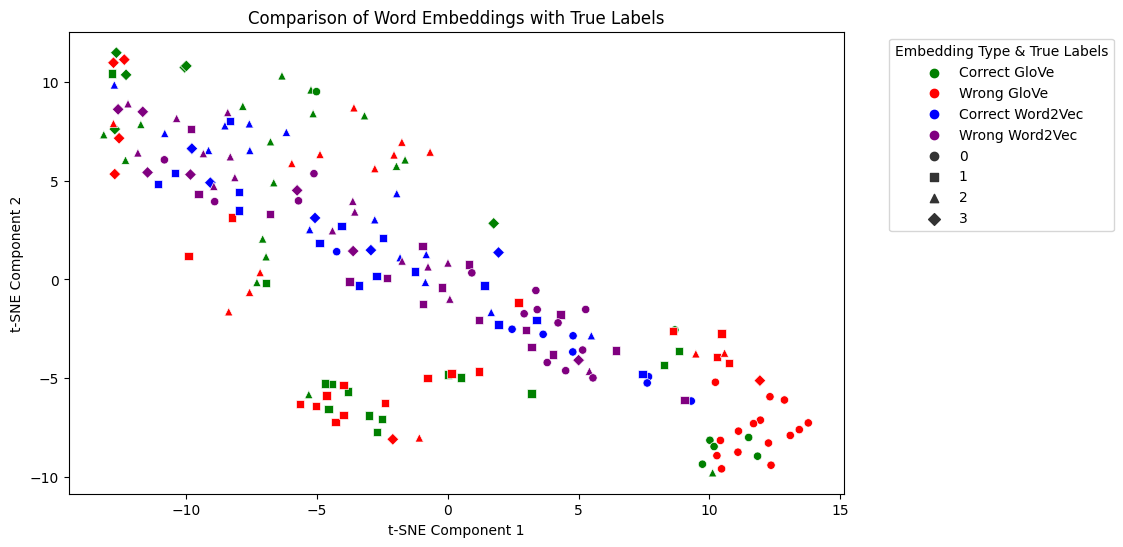

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Collect data for visualization
correct_glove = []
wrong_glove = []
correct_w2v = []
wrong_w2v = []
true_labels = []

for text, _, glove_features in correctly_classified_sentences.get("SVM (GloVe)", []):
    correct_glove.append(glove_features)
    true_labels.append(data.loc[data["Translated"] == text, "Label"].values[0])
for text, _, glove_features in misclassified_sentences.get("SVM (GloVe)", []):
    wrong_glove.append(glove_features)
    true_labels.append(data.loc[data["Translated"] == text, "Label"].values[0])
for text, _, w2v_features in correctly_classified_sentences.get("SVM (Word2Vec)", []):
    correct_w2v.append(w2v_features)
    true_labels.append(data.loc[data["Translated"] == text, "Label"].values[0])
for text, _, w2v_features in misclassified_sentences.get("SVM (Word2Vec)", []):
    wrong_w2v.append(w2v_features)
    true_labels.append(data.loc[data["Translated"] == text, "Label"].values[0])

# Convert lists to arrays
label_map = {
    "Correct GloVe": correct_glove,
    "Wrong GloVe": wrong_glove,
    "Correct Word2Vec": correct_w2v,
    "Wrong Word2Vec": wrong_w2v
}

# Filter out empty arrays before concatenating
all_features = []
labels = []
all_true_labels = []  # Store corresponding labels

for label, array in label_map.items():
    array = np.array(array)
    if array.shape[0] > 0:
        all_features.append(array)
        labels.extend([label] * len(array))
        all_true_labels.extend(true_labels[:len(array)])
        true_labels = true_labels[len(array):]  # Shift to match remaining data

# Ensure all_features is not empty before applying t-SNE
if all_features:
    all_features = np.vstack(all_features)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(all_features)

    # Define colors for each embedding type
    palette = {
        "Correct GloVe": "green",
        "Wrong GloVe": "red",
        "Correct Word2Vec": "blue",
        "Wrong Word2Vec": "purple"
    }

    # Define marker styles based on label classes
    unique_labels = list(set(all_true_labels))
    markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']  # Assign unique markers
    marker_map = {label: markers[i % len(markers)] for i, label in enumerate(unique_labels)}

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette=palette, style=all_true_labels, markers=marker_map)
    
    plt.title("Comparison of Word Embeddings with True Labels")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(title="Embedding Type & True Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()
else:
    print("No data available for visualization.")


## Mutlivariate Bayesian

In [5]:
from collections import defaultdict

# Prepare data grouped by POS tag
pos_tagged_vectors = defaultdict(list)

for tokens, pos_tags in zip(tokenized_texts, pos_tagged_texts):
    for word, (original_word, pos_tag_label) in zip(tokens, pos_tags):
        if word in word2vec_model.wv:
            vector = word2vec_model.wv[word]
            pos_tagged_vectors[pos_tag_label].append(vector)


In [6]:
from scipy.stats import multivariate_normal

gaussian_models = {}

for pos_tag_label, vectors in pos_tagged_vectors.items():
    vectors = np.array(vectors)
    
    if len(vectors) < 2:
        # Not enough samples for covariance, handle gracefully
        print(f"Skipping POS tag '{pos_tag_label}' due to insufficient data ({len(vectors)} sample).")
        continue
    
    mean_vector = np.mean(vectors, axis=0)
    cov_matrix = np.cov(vectors, rowvar=False)
    
    # Fix for numerical stability
    if cov_matrix.ndim == 0:  # In case it's scalar
        cov_matrix = np.eye(vectors.shape[1]) * 1e-6
    else:
        cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6
    
    gaussian_models[pos_tag_label] = multivariate_normal(mean=mean_vector, cov=cov_matrix)


Skipping POS tag 'UH' due to insufficient data (1 sample).


In [7]:
if len(vectors) < 2:
    mean_vector = vectors[0]
    cov_matrix = np.eye(len(mean_vector)) * 1e-6


## Bayesian and Prior Probabilities

In [12]:


import numpy as np
from collections import defaultdict, Counter
from tqdm import tqdm
from scipy.stats import multivariate_normal

# 1️⃣ Compute prior probabilities of POS tags
all_pos_tags = [tag for sent in pos_tagged_texts for (_, tag) in sent]
total_tags = len(all_pos_tags)
tag_counts = Counter(all_pos_tags)
pos_tag_priors = {tag: count / total_tags for tag, count in tag_counts.items()}

# 2️⃣ Train Multivariate Gaussians for each POS tag
pos_tag_embeddings = defaultdict(list)

for sentence in tqdm(pos_tagged_texts):
    for word, tag in sentence:
        if word in word2vec_model.wv:
            embedding = word2vec_model.wv[word]
            pos_tag_embeddings[tag].append(embedding)

gaussian_models = {}
min_samples = 5  # Ignore tags with too few samples

for tag, embeddings in pos_tag_embeddings.items():
    if len(embeddings) < min_samples:
        print(f"Skipping POS tag '{tag}' due to insufficient data ({len(embeddings)} samples).")
        continue
    embeddings_array = np.array(embeddings)
    mean_vector = np.mean(embeddings_array, axis=0)
    cov_matrix = np.cov(embeddings_array, rowvar=False)

    cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6

    gaussian_models[tag] = multivariate_normal(mean=mean_vector, cov=cov_matrix)


# 3️⃣ Prediction function with priors
def predict_pos_tags_with_bayes(tokens):
    predicted_tags = []
    for word in tokens:
        if word in word2vec_model.wv:
            embedding = word2vec_model.wv[word]
            tag_scores = {}
            for tag, gaussian in gaussian_models.items():
                likelihood = gaussian.pdf(embedding)
                prior = pos_tag_priors.get(tag, 1e-6)  # Small value if unseen
                score = likelihood * prior
                tag_scores[tag] = score
            predicted_tag = max(tag_scores, key=tag_scores.get)
        else:
            predicted_tag = 'UNK'  # Unknown word
        predicted_tags.append((word, predicted_tag))
    return predicted_tags


100%|██████████| 480/480 [00:00<00:00, 8589.35it/s]

Skipping POS tag 'UH' due to insufficient data (1 samples).
Skipping POS tag 'RBS' due to insufficient data (3 samples).


In [13]:
# Take a sample sentence from your dataset
sample_sentence_from_data = pos_tagged_texts[0]  # First sentence in the dataset
sample_words = [word for word, tag in sample_sentence_from_data]

# Predict POS tags
predicted_tags = predict_pos_tags_with_bayes(sample_words)

# Show results
print("\nPredicted POS tags (with priors) for a sample sentence from the dataset:")
for word, tag in predicted_tags:
    print(f"{word} → {tag}")



Predicted POS tags (with priors) for a sample sentence from the dataset:
after → IN
hacking → VBG
state → NN
tv → NN
by → IN
replacing → VBG
propaganda → NN
images → NNS
with → IN
real → JJ
ones → NNS
they → PRP
directly → NN
addressed → VBD
putin → JJ
's → POS
`` → ``
against → IN
us → PRP
you → PRP
can → MD
not → RB
win → VB
'' → ''
and → CC
the → DT
soldiers → NNS
on → IN
the → DT
front → NN
lines → NN
with → IN
a → DT
call → VB
to → TO
lay → VB
down → RP
their → PRP$
weapons → NNS
. → .
today → NN
you → PRP
can → MD
fight → VB
a → DT
war → NN
without → IN
firing → VBG
a → DT
shot → VBD
. → .
respect → NN


In [14]:
import pandas as pd

# Store predictions for all sentences
all_predictions = []

# Loop through every sentence in your dataset
for sentence in tqdm(pos_tagged_texts):
    words = [word for word, _ in sentence]
    predicted_tags = predict_pos_tags_with_bayes(words)
    
    all_predictions.append({
        "sentence": " ".join(words),
        "predicted_tags": " ".join([f"{word}/{tag}" for word, tag in predicted_tags])
    })

# Convert to DataFrame for easy viewing and saving
predictions_df = pd.DataFrame(all_predictions)

# Display first few predictions
print(predictions_df.head())

# ✅ Save to CSV
predictions_df.to_csv("pos_tag_predictions.csv", index=False)
print("Predictions saved to pos_tag_predictions.csv")


100%|██████████| 480/480 [00:34<00:00, 13.94it/s]

                                            sentence  \
0  after hacking state tv by replacing propaganda...   
1  # flowers # lovers make love not war . marc ch...   
2  if only we all showed more love and understand...   
3  who are the soldiers we see in the videos ? ar...   
4  i did n't think # salvini could make his posit...   

                                      predicted_tags  
0  after/IN hacking/VBG state/NN tv/NN by/IN repl...  
1  #/# flowers/NNS #/# lovers/NNS make/VBP love/N...  
2  if/IN only/RB we/PRP all/PDT showed/VBD more/R...  
3  who/WP are/VBP the/DT soldiers/NNS we/PRP see/...  
4  i/VBP did/VBD n't/RB think/VBP #/# salvini/JJ ...  
Predictions saved to pos_tag_predictions.csv


## Visualizing the Path taken

since i have used networkx it looks a bit off

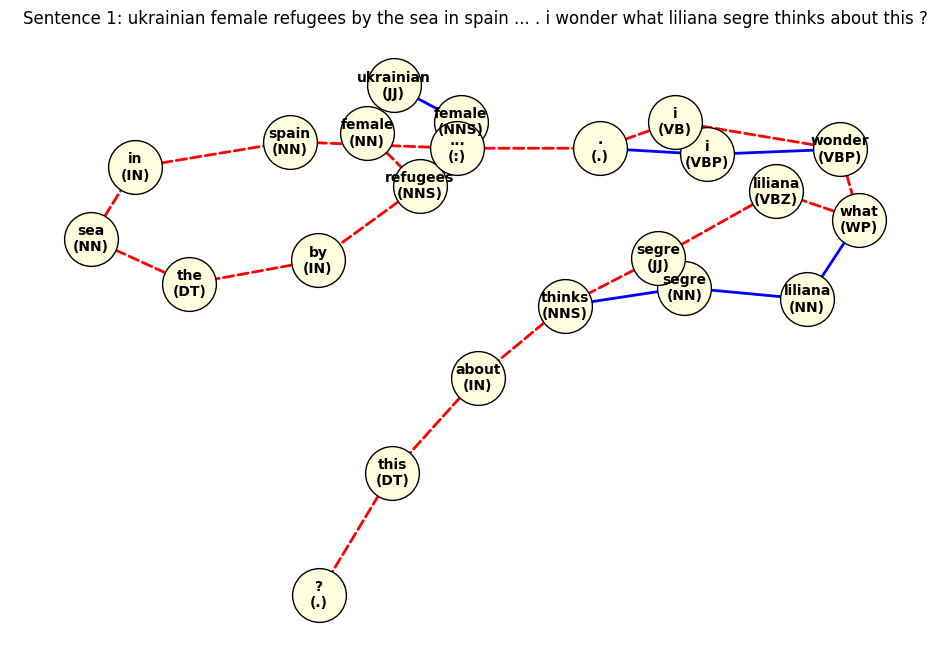

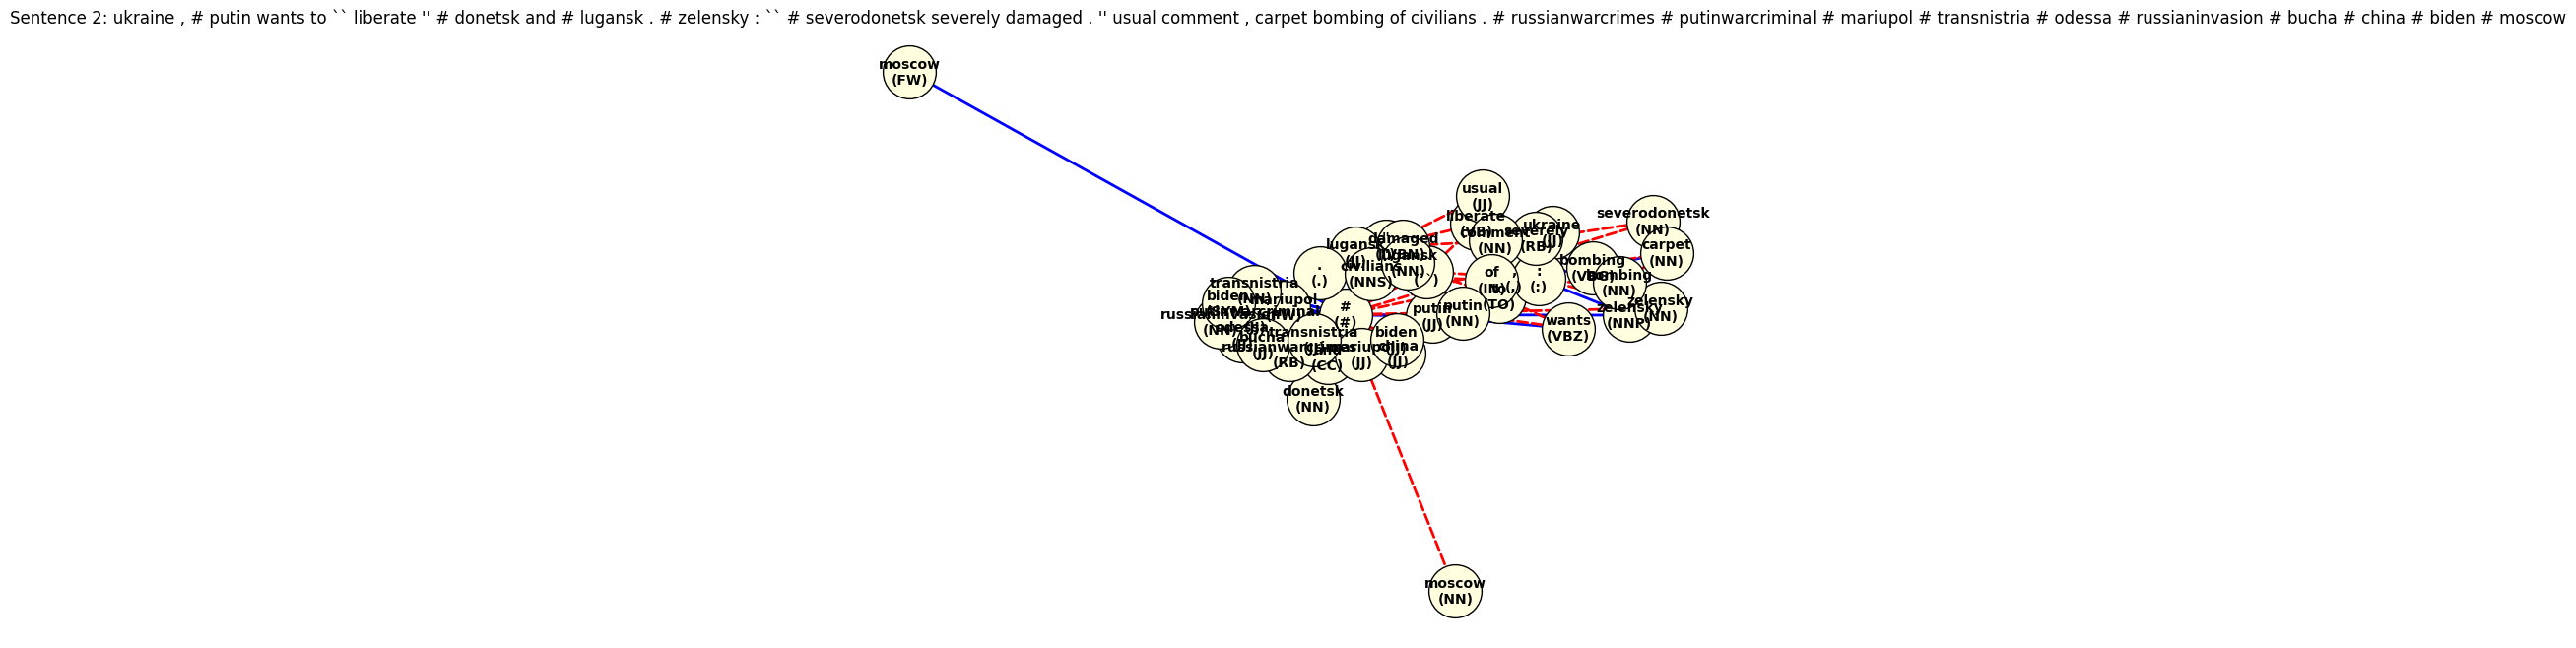

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127462 (\N{REGIONAL INDICATOR SYMBOL LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


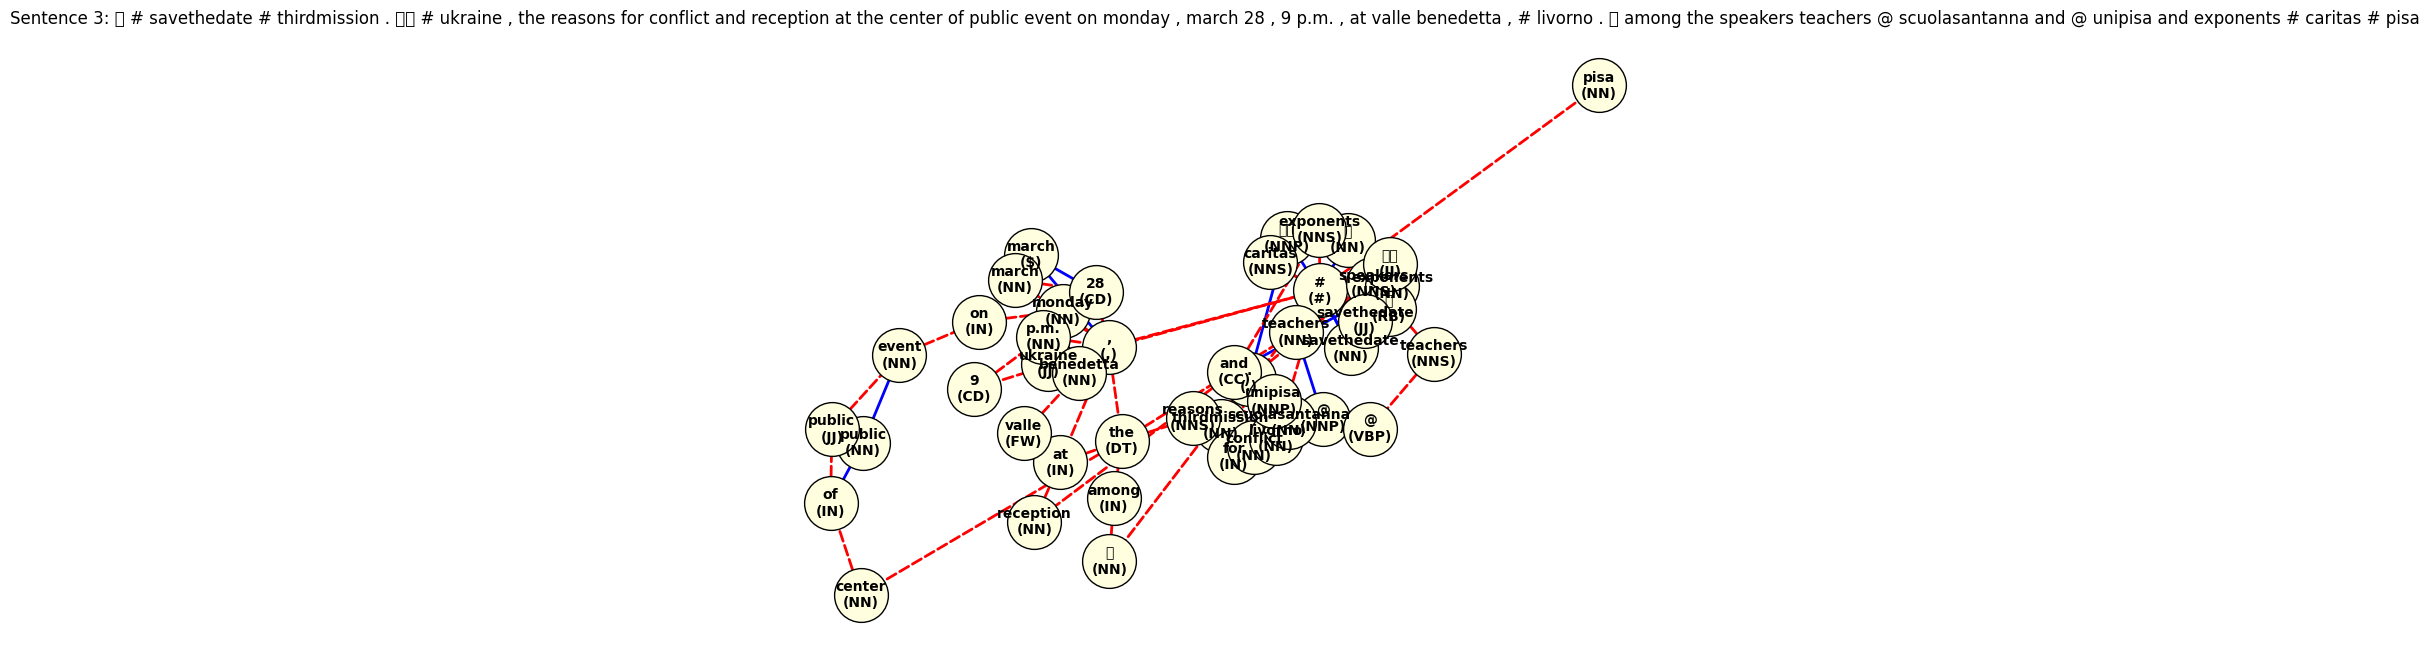

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
from nltk import pos_tag
import random

# Select a few random sample sentences from your dataset
sample_sentences = random.sample(pos_tagged_texts, 3)

for idx, sentence in enumerate(sample_sentences):
    words = [word for word, _ in sentence]
    
    # Predicted POS tags from your Bayesian model
    bayes_tags = [tag for _, tag in predict_pos_tags_with_bayes(words)]
    
    # Alternative POS tags from NLTK (for comparison)
    nltk_tags = [tag for _, tag in pos_tag(words)]
    
    # Initialize a directed graph
    G = nx.DiGraph()
    
    # Add nodes and edges for Bayesian POS path
    for i, (word, bayes_tag) in enumerate(zip(words, bayes_tags)):
        G.add_node(f"{word}\n({bayes_tag})", color='lightblue')
        if i > 0:
            prev_word = words[i - 1]
            prev_tag = bayes_tags[i - 1]
            G.add_edge(f"{prev_word}\n({prev_tag})", f"{word}\n({bayes_tag})", color='blue', label="Bayes")
    
    # Add alternative NLTK POS path as dotted edges
    for i in range(1, len(words)):
        prev_word = words[i - 1]
        prev_tag = nltk_tags[i - 1]
        curr_word = words[i]
        curr_tag = nltk_tags[i]
        G.add_edge(f"{prev_word}\n({prev_tag})", f"{curr_word}\n({curr_tag})", color='red', style='dashed', label="NLTK")
    
    # Visualization
    pos = nx.spring_layout(G, seed=42)
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]
    edge_styles = [G[u][v].get('style', 'solid') for u, v in G.edges()]
    
    plt.figure(figsize=(12, 8))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightyellow', node_size=1500, edgecolors='black')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # Draw edges with styles
    for style in set(edge_styles):
        idxs = [i for i, s in enumerate(edge_styles) if s == style]
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[list(G.edges())[i] for i in idxs],
            edge_color=[edge_colors[i] for i in idxs],
            style=style,
            width=2
        )
    
    plt.title(f"Sentence {idx + 1}: {' '.join(words)}")
    plt.axis('off')
    plt.show()


In [16]:
predictions_df

,sentence,predicted_tags
0,after hacking state tv by replacing propaganda...,after/IN hacking/VBG state/NN tv/NN by/IN repl...
1,# flowers # lovers make love not war . marc ch...,#/# flowers/NNS #/# lovers/NNS make/VBP love/N...
2,if only we all showed more love and understand...,if/IN only/RB we/PRP all/PDT showed/VBD more/R...
3,who are the soldiers we see in the videos ? ar...,who/WP are/VBP the/DT soldiers/NNS we/PRP see/...
4,i did n't think # salvini could make his posit...,i/VBP did/VBD n't/RB think/VBP #/# salvini/JJ ...
...,...,...
475,if i write that ms. # zelensky was allegedly s...,if/IN i/VBP write/VBP that/WDT ms./NN #/# zele...
476,# zelensky and his wife # olenazelenska bought...,#/# zelensky/NNP and/CC his/PRP$ wife/NN #/# o...
477,all united against dragons against war against...,all/PDT united/VBN against/IN dragons/NNS agai...
478,all united against dragons against war against...,all/PDT united/VBN against/IN dragons/NNS agai...


## Evaluating the POS tags

In [23]:
import pandas as pd

# Load original dataset
new_data = pd.read_csv("/kaggle/input/filtered-and-translated-nlp/filr.csv")


new_data['predicted_tags']= predictions_df['predicted_tags']

In [25]:
new_data

,Unnamed: 0.1,Unnamed: 0,ID,URL,Type,Label,Content,Image_Name,Cleaned_Text,Translated,predicted_tags
0,0,0,1498022438398877704,https://twitter.com/manuela_carloni/status/149...,tweet,1,Dopo aver hackerato la tv di Stato sostituendo...,1498022438398877704.jpg,Dopo aver hackerato la tv di Stato sostituendo...,After hacking state TV by replacing propaganda...,after/IN hacking/VBG state/NN tv/NN by/IN repl...
1,2,2,1497887473862467584,https://twitter.com/barbarameletto/status/1497...,tweet,2,#flowers #lovers\nFate l'amore non fate la gue...,1497887473862467584.jpg,#flowers #lovers\nFate l'amore non fate la gue...,#flowers #lovers\nMake love not war.\nMarc Cha...,#/# flowers/NNS #/# lovers/NNS make/VBP love/N...
2,3,3,1497838543619645441,https://twitter.com/_dani_ta_6/status/14978385...,tweet,2,Se solo tutti mostrassimo più amore e comprens...,1497838543619645441.jpg,Se solo tutti mostrassimo più amore e comprens...,If only we all showed more love and understand...,if/IN only/RB we/PRP all/PDT showed/VBD more/R...
3,4,4,1497639979534667783,https://twitter.com/GabrieleGranato/status/149...,tweet,2,Chi sono i soldati che vediamo nei video? Sono...,1497639979534667783.jpg,Chi sono i soldati che vediamo nei video? Sono...,Who are the soldiers we see in the videos? Are...,who/WP are/VBP the/DT soldiers/NNS we/PRP see/...
4,5,5,1497624763396546561,https://twitter.com/nonleggerlo/status/1497624...,tweet,1,Non credevo che #Salvini potesse peggiorare la...,1497624763396546561.jpg,Non credevo che #Salvini potesse peggiorare la...,I didn't think #Salvini could make his positio...,i/VBP did/VBD n't/RB think/VBP #/# salvini/JJ ...
...,...,...,...,...,...,...,...,...,...,...,...
475,718,718,1538486694701408256,https://twitter.com/fratotolo2/status/15384866...,tweet,1,Se scrivo che la signora #Zelensky sarebbe sta...,1538486694701408256.jpg,Se scrivo che la signora #Zelensky sarebbe sta...,If I write that Ms. #Zelensky was allegedly sp...,if/IN i/VBP write/VBP that/WDT ms./NN #/# zele...
476,721,721,1538254178413322241,https://twitter.com/104Pierpa/status/153825417...,tweet,0,#Zelensky e sua moglie #OlenaZelenska hanno ac...,1538254178413322241.jpg,#Zelensky e sua moglie #OlenaZelenska hanno ac...,#Zelensky and his wife #OlenaZelenska bought a...,#/# zelensky/NNP and/CC his/PRP$ wife/NN #/# o...
477,722,722,1537840889749458946,https://twitter.com/PartitComunista/status/153...,tweet,2,TUTTI UNITI CONTRO DRAGHI\nCONTRO LA GUERRA\nC...,1537840889749458946.jpg,TUTTI UNITI CONTRO DRAGHI\nCONTRO LA GUERRA\nC...,ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...,all/PDT united/VBN against/IN dragons/NNS agai...
478,726,726,1535923240710946816,https://twitter.com/PartitComunista/status/153...,tweet,2,TUTTI UNITI CONTRO DRAGHI\nCONTRO LA GUERRA\nC...,1535923240710946816.jpg,TUTTI UNITI CONTRO DRAGHI\nCONTRO LA GUERRA\nC...,ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...,all/PDT united/VBN against/IN dragons/NNS agai...


In [26]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import word_tokenize
from tqdm import tqdm



# Load GloVe 200d embeddings
glove_path = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
glove_embeddings = {}

with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glove_embeddings[word] = vector

embedding_dim = 200

# Function to get average GloVe embedding of POS-tagged sentence
def pos_glove_embedding(pos_tagged_text):
    tokens = [pair.split('/')[0].lower() for pair in pos_tagged_text.split() if '/' in pair]
    embeddings = [glove_embeddings[word] for word in tokens if word in glove_embeddings]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_dim)

# Apply the embedding function to all data
tqdm.pandas()
new_data['embedding'] = new_data['predicted_tags'].progress_apply(pos_glove_embedding)

# Prepare features and labels
X = np.vstack(new_data['embedding'].values)
y = new_data['Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train the SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predict
y_pred = svm_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ SVM Accuracy using POS-tagged GloVe embeddings: {accuracy:.4f}\n")
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred))


100%|██████████| 480/480 [00:00<00:00, 14640.44it/s]


✅ SVM Accuracy using POS-tagged GloVe embeddings: 0.5208


✅ Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.60      0.58        15
           1       0.55      0.26      0.35        23
           2       0.51      0.85      0.64        41
           3       0.00      0.00      0.00        17

    accuracy                           0.52        96
   macro avg       0.40      0.43      0.39        96
weighted avg       0.44      0.52      0.45        96




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
